# Example ERA5 

### Time period

We will use data from 1985 to 2014.

### Variables 

| shortname     |             Long name                   |      Units    |  levels |
| ------------- |:---------------------------------------:| -------------:|--------:|
| sf            |    snowfall                             |[m of water eq]| surface |
| msr           |    mean_snowfall_rate                   |[kg m-2 s-1]   | surface |
| cswc          |    specific_snow_water_content          | [kg kg-1]     |    pl   |
| clwc          |    specific_cloud_liquid_water_content  |   [kg kg-1]   |    pl   |
| clic          |    specific_cloud_ice_water_content     | [kg kg-1]     |    pl   |
| t             |    temperature                          |  [K]          |    pl   |
| 2t            |    2 metre temperature                  |  [K]          | surface |
| tclw          |   Total column cloud liquid water       |  [kg m-2]     | single  |
| tciw          |   Total column cloud ice water          |  [kg m-2]     | single  |
| tp            |   Total precipitation                   |  [m]          | surface |






## Import python packages

In [40]:

# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
import sys
sys.path.append('/uio/kant/geo-metos-u1/franzihe/Documents/Python/globalsnow/eosc-nordic-climate-demonstrator/work/utils')
import xarray as xr
xr.set_options(display_style='html')
import intake
import cartopy.crs as ccrs
import cartopy as cy
import matplotlib.pyplot as plt
from glob import glob
from cmcrameri import cm

import functions as fct



In [41]:
# reload imports
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Open ERA5 variables

In [42]:
input_data = '/scratch/franzihe/input'
output_data = '/scratch/franzihe/output'

In [43]:
era_in = '{}/ERA5/monthly_means/0.25deg'.format(input_data)
era_out = '{}/ERA5/monthly_means/1deg'.format(output_data)

variable_id=[
            # 'sf', 
            # 'tciw',
            # 'tclw',
            # '2t'
            'tp'
             ]

# Regrid ERA5 data to common NorESM2-MM grid

In [44]:

starty = 1985; endy = 2014
year_range = range(starty, endy+1)

# Read in regridder data (NorESM)
cmip_file = '/scratch/franzihe/input/cmip6_hist/1deg/grid_NorESM2-MM.nc'
ds_out = xr.open_dataset(cmip_file)

counter = 0
for var_id in variable_id:
    # select where data should be saved
    filename = '{}_Amon_1deg_{}01_{}12.nc'.format(var_id, starty, endy)
    era_file_out = era_out + '/Amon/' + filename
    files = glob(era_file_out)
            
    
    
    # Input data from ERA5 with a resolution of 0.25x0.25deg to be regridded
    era_file_in = glob('{}/{}_Amon_ERA5_*12.nc'.format(era_in, var_id,))        
    ds_in = xr.open_mfdataset(era_file_in)
    ds_in = ds_in.sel(time = ds_in.time.dt.year.isin(year_range)).squeeze()
            
    # Regrid data
    ds_in_regrid = fct.regrid_data(ds_in, ds_out)
                
    # Shift the longitude from 0-->360 to -180-->180 and sort by longitude and time
    ds_in_regrid = ds_in_regrid.assign_coords(lon=(((ds_in_regrid.lon + 180) % 360) - 180)).sortby('lon').sortby('time')
    
    if variable_id[0] == '2t':
        ds_in_regrid = ds_in_regrid.rename_vars({'t2m':var_id}, )
                
    if era_file_out in files:
        print('{} is downloaded'.format(era_file_out))
        counter += 1
        print('Have regridded in total: {:} files'.format(str(counter))) 
    else:           
        # Save to netcdf file
        ds_in_regrid.to_netcdf(era_file_out)
        ds_in.close(); ds_out.close()
        print('file written: {}'.format(era_file_out))
        
    

Create weight file: bilinear_721x1440_192x288.nc
Remove file bilinear_721x1440_192x288.nc
using dimensions ('lat', 'lon') from data variable tp as the horizontal dimensions for this dataset.
tp True
file written: /scratch/franzihe/output/ERA5/monthly_means/1deg/Amon/tp_Amon_1deg_198501_201412.nc


# Assign attributes matching the CMIP6 data

In [45]:
if variable_id[0] == 'sf':
    ds_in_regrid[variable_id[0]] = ds_in_regrid[variable_id[0]]*1000
    ds_in_regrid[variable_id[0]].attrs = {'units': 'mm day-1', 'long_name': 'Snowfall',}
    
if variable_id[0] == 'tciw':
    ds_in_regrid[variable_id[0]] = ds_in_regrid[variable_id[0]]*1000
    ds_in_regrid[variable_id[0]].attrs = {'units': 'g m-2', 'long_name': 'Total column cloud ice water'}
    
if variable_id[0] == 'tclw':
    ds_in_regrid[variable_id[0]] = ds_in_regrid[variable_id[0]]*1000
    ds_in_regrid[variable_id[0]].attrs = {'units': 'g m-2', 'long_name': 'Total column cloud liquid water'}
if variable_id[0] == 'tp':
    # The hydrological parameters have effective units of "m of water per day" and so they should be multiplied by 1000 to convert to kgm-2day-1 or mmday-1.
    ds_in_regrid[variable_id[0]] = ds_in_regrid[variable_id[0]]*1000
    ds_in_regrid[variable_id[0]].attrs = {'units': 'mm day-1', 'long_name': 'Total precipitation'}
    

    

# Create seasonal mean/spread of all regridded ERA5

...and plot seasonal mean of each individual model

In [46]:
ds_in_regrid[variable_id[0]+'_season_mean'] = ds_in_regrid[variable_id[0]].groupby('time.season').mean('time', keep_attrs = True)

ds_in_regrid[variable_id[0]+'_season_std'] = ds_in_regrid[variable_id[0]].groupby('time.season').std('time', keep_attrs = True)

In [47]:
if variable_id[0] == 'sf':
    label='Snowfall (mm$\,$day$^{-1}$)'
    vmin = 0
    vmax = 2.5
    levels = 25
    add_colorbar=False
    vmin_std = vmin
    vmax_std= 0.6
if variable_id[0] == 'tp':  
    label='Total precipitation (mm$\,$day$^{-1}$)' 
    vmin = 0
    vmax=9
    levels = 90
    add_colorbar=False
    vmin_std =vmin
    vmax_std = 2.4  
if variable_id[0] == 'tciw':
    label='Ice Water Path (g$\,$m$^{-2}$)'
    vmin = 0
    vmax=100
    levels = 25
    add_colorbar = False
    vmin_std =vmin
    vmax_std = 20
if variable_id[0] == 'tclw':
    label='Liquid Water Path (g$\,$m$^{-2}$)'
    vmin = 0
    vmax=100
    levels = 25
    add_colorbar = False
    vmin_std =vmin
    vmax_std = 20
if variable_id[0] == '2t':
    label='2-m temperature (K)'
    vmin = 246
    vmax=300
    levels = 40
    add_colorbar = False
    vmin_std = 0
    vmax_std=6


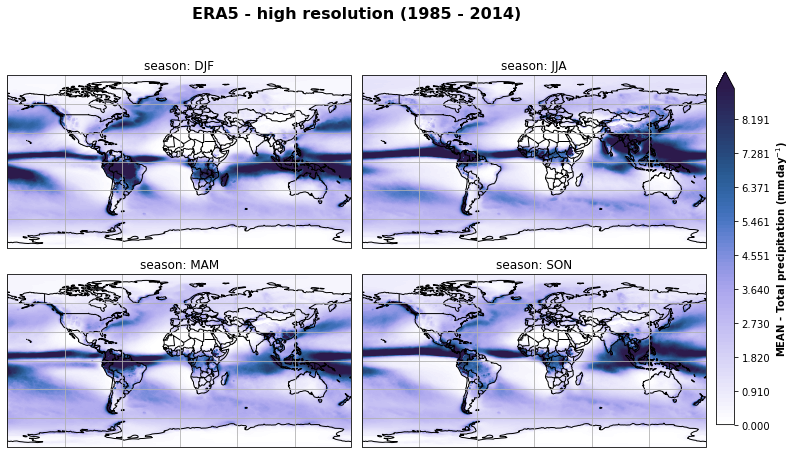

In [48]:
fig, axs, im = fct.plt_spatial_seasonal_mean(ds_in_regrid[variable_id[0]+'_season_mean'], vmin, vmax, levels, add_colorbar=False, title='ERA5 - high resolution (1985 - 2014)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
cb.set_label(label='MEAN - {}'.format(label), weight='bold')

plt.tight_layout()

# save figure to png
figdir = '/uio/kant/geo-metos-u1/franzihe/Documents/Figures/ERA5/'
figname = '{}_season_1deg_{}_{}.png'.format(variable_id[0], starty, endy)
plt.savefig(figdir + figname, format = 'png', bbox_inches = 'tight', transparent = False)

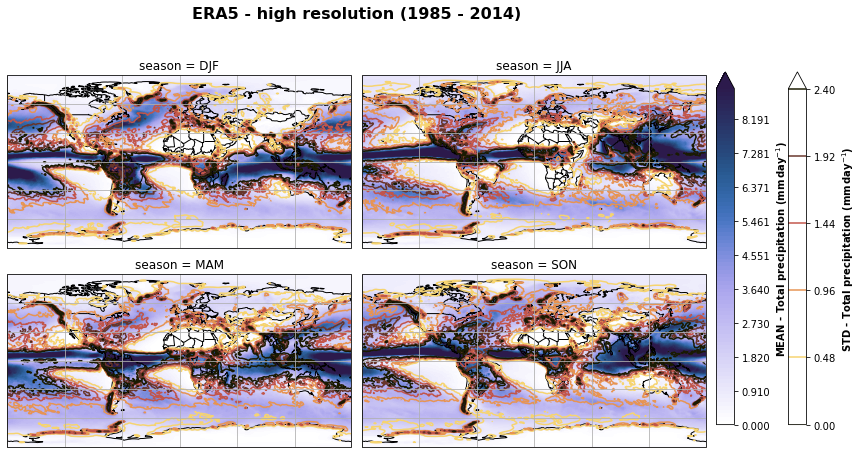

In [49]:
fig, axs, im = fct.plt_spatial_seasonal_mean(ds_in_regrid[variable_id[0]+'_season_mean'], vmin, vmax, levels, add_colorbar=False, title='ERA5 - high resolution (1985 - 2014)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
cb.set_label(label='MEAN - {}'.format(label), weight='bold')

for ax, i in zip(axs, ds_in_regrid[variable_id[0]+'_season_std'].season):
    sm = ds_in_regrid[variable_id[0]+'_season_std'].sel(season=i).plot.contour(ax=ax, transform=ccrs.PlateCarree(), 
                                                                      robust=True,
                                                                      vmin = vmin_std, vmax = vmax_std,
                                                                       levels = 6,
                                                                      cmap=cm.lajolla,
                                                                      add_colorbar=False)
    
cbar_ax = fig.add_axes([1.10, 0.15, 0.025, 0.7])
sb = fig.colorbar(sm, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
sb.set_label(label='STD - {}'.format(label), weight='bold')


plt.tight_layout()


In [50]:
# save to netcdf
filename = '{}_1deg_{}01_{}12.nc'.format(variable_id[0], starty, endy)
nc_out = era_out + '/' + filename
files = glob(nc_out)


counter = 0 
# Save to netcdf file
if nc_out in files:
    print('{} is downloaded'.format(nc_out))
    counter += 1
    print('Have saved in total: {:} files'.format(str(counter)))
else:
    ds_in_regrid.to_netcdf(nc_out)
    print('file written: .{}'.format(nc_out))


file written: ./scratch/franzihe/output/ERA5/monthly_means/1deg/tp_1deg_198501_201412.nc
